# 04a Rank CATE estimators GI

In the previous notebook, we saw that estimators do not have good prediction performance, and neither are  
they sufficiently stable in general. On the other hand, the banded ordering of individuals generalizes. In  
this notebook, we measure this generalization performance in terms of the $t$-statistic. We rank the  
various estimators w.r.t. this statistic, and select the ones with which to form an ensemble.

The data perturbations are:  
1. No perturbation  
2. Stratified CV split with different random seed  
3. Another stratified CV split with different random seed  
4. CV split using enrollment time to define folds  
5. Replacing overweight feature with obese (using a different BMI threshold)  
6. Changing age threshold for elderly feature from 65 to 60  
7. Changing the outcome of interest to all GI events instead of just confirmed GI events  

### Contents:
1. Set up  
1.1. Create, save and/or load the scores data frame  
2. Aggregate the $t$-statistics in various ways  
2.1. Aggregate within each data perturbation  
2.2. Aggregate within each q value  
2.3. Aggregate over everything  
3. $t$-statistic variability  
4. Selecting the top estimators  
4.1. Further investigation and plots  
4.2. Outputting names of top estimators

## 1. Set up

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import own methods
from methods.cate_estimator_validation import (get_estimator_scores, aggregate_estimator_scores, 
                                               get_t_r2_statistics)

Failed to import duecredit due to No module named 'duecredit'


If scores are already cached, load them instead of running 1.1.

### 1.1. Create, save and/or load the scores data frame

Compute the t-statistics for the different estimators across different folds and data perturbations. Store the result in the  data frame ``scores_df``.

In [3]:
# Load the scores data frame
outcome_name = "fausebal"
q_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
dir_neg = False
try: 
    scores_df = joblib.load(f"output/analysis/{outcome_name}/{outcome_name}_scores_df.pkl")
except:
    file_path = f"output/analysis/{outcome_name}/{outcome_name}_fitted_libraries.pkl"
    fitted_libraries = joblib.load(file_path)
    scores_df = get_estimator_scores(fitted_libraries, q_values, 
                                    dir_neg=dir_neg, kind = "val")
    joblib.dump(scores_df, f"output/analysis/{outcome_name}/{outcome_name}_scores_df.pkl")
    del fitted_libraries

## 2. Aggregate the $t$-statistics in various ways

### 2.1. Aggregate within each data perturbation

In [4]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by="perturbation", dir_neg=dir_neg)
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [5]:
results_df.round(2)

pert=cv_0  pert=none  pert=cv_1  mean
estimator                                             
s_xgb                -0.04       0.07       0.47  0.17
s_rf                 -0.29       0.13      -0.06 -0.08
t_lasso              -0.60      -0.10      -0.25 -0.32
t_logistic           -0.88      -0.59      -0.62 -0.70
t_rf                 -0.12       0.18       0.34  0.13
t_xgb                -0.63       0.55       0.64  0.19
x_lasso              -0.80      -0.43      -0.16 -0.46
x_logistic           -0.73      -0.44      -0.43 -0.54
x_rf                 -0.73      -0.56      -0.52 -0.60
x_xgb                -0.41      -0.41      -0.35 -0.39
r_lassolasso          0.06      -0.00       0.03  0.03
r_lassoxgb           -0.95       0.27      -0.21 -0.30
r_lassorf            -1.01      -0.56      -0.05 -0.54
r_rflasso             0.06      -0.00       0.03  0.03
r_rfrf               -1.37      -0.78       0.24 -0.64
r_rfxgb              -1.03      -0.14      -0.04 -0.40
r_xgblasso            0.06      -0.00       0.03  0.03
r_xgbrf              -1.34      -0.53       0.26 -0.54
r_xgbxgb             -1.14       0.10      -0.30 -0.44
causal_tree_1        -0.60      -0.17       0.24 -0.18
causal_tree_2         0.05      -0.08       0.35  0.10
causal_forest_1      -1.36      -0.57       0.21 -0.58
causal_forest_2      -0.64      -0.50       0.26 -0.29

In [6]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="rank_mean", 
                                        group_by="perturbation", dir_neg=dir_neg)
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [7]:
results_df.sort_values("mean").round(2)

pert=cv_0  pert=none  pert=cv_1   mean
estimator                                              
t_rf                  7.75       8.00       9.25   8.33
s_xgb                 7.10      10.15       7.90   8.38
t_xgb                12.10       6.45       6.80   8.45
causal_tree_2         6.95       9.25      10.00   8.73
s_rf                  9.15       9.45      13.05  10.55
causal_tree_1        11.00      12.30       9.30  10.87
r_rflasso             8.95      11.55      12.80  11.10
r_lassolasso          8.95      11.55      12.80  11.10
r_xgblasso            8.95      11.55      12.80  11.10
t_lasso              11.75       9.85      13.00  11.53
causal_forest_2      11.20      14.55       9.45  11.73
r_lassoxgb           14.05       9.10      13.25  12.13
x_xgb                11.20      13.05      14.60  12.95
x_lasso              12.60      13.25      13.10  12.98
r_rfxgb              14.20      12.80      12.35  13.12
x_logistic           11.70      13.95      14.80  13.48
r_xgbxgb             15.40      10.50      14.60  13.50
causal_forest_1      16.65      14.15      10.80  13.87
r_xgbrf              17.30      15.00       9.95  14.08
r_lassorf            15.20      14.35      12.85  14.13
x_rf                 12.10      14.80      16.65  14.52
t_logistic           14.30      13.90      15.65  14.62
r_rfrf               17.45      16.50      10.25  14.73

### 2.2. Aggregated within each q value

In [8]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by="q_value", dir_neg=dir_neg)
results_df["mean"] = results_df.apply(np.mean, axis = 1)

In [9]:
results_df.sort_values("mean").round(2)

0.1   0.2   0.3   0.4   0.5  mean
estimator                                          
t_logistic      -0.18 -0.68 -0.84 -1.01 -0.79 -0.70
r_rfrf          -1.06 -1.07 -0.64 -0.51  0.10 -0.64
x_rf            -0.73 -0.61 -0.72 -0.63 -0.33 -0.60
causal_forest_1 -0.84 -1.03 -0.61 -0.13 -0.27 -0.58
r_lassorf       -0.28 -0.72 -0.71 -0.76 -0.24 -0.54
r_xgbrf         -0.91 -0.79 -0.64 -0.38  0.03 -0.54
x_logistic      -0.46 -0.39 -0.39 -0.74 -0.70 -0.54
x_lasso         -0.34 -0.45 -0.42 -0.46 -0.65 -0.46
r_xgbxgb        -0.57 -0.38 -0.48 -0.51 -0.28 -0.44
r_rfxgb         -0.87 -0.41 -0.44 -0.25 -0.06 -0.40
x_xgb           -0.36 -0.78 -0.37 -0.27 -0.16 -0.39
t_lasso         -0.08 -0.37 -0.10 -0.51 -0.52 -0.32
r_lassoxgb      -0.64 -0.48 -0.09 -0.06 -0.22 -0.30
causal_forest_2 -0.46 -0.57 -0.36 -0.19  0.11 -0.29
causal_tree_1   -0.49 -0.17 -0.14 -0.17  0.08 -0.18
s_rf             0.14 -0.10 -0.18 -0.12 -0.12 -0.08
r_lassolasso    -0.08  0.13  0.29 -0.10 -0.09  0.03
r_xgblasso      -0.08  0.13  0.29 -0.10 -0.09  0.03
r_rflasso       -0.08  0.13  0.29 -0.10 -0.09  0.03
causal_tree_2   -0.09  0.24 -0.01  0.12  0.24  0.10
t_rf             0.15 -0.00  0.20  0.23  0.08  0.13
s_xgb            0.25  0.13  0.19  0.10  0.16  0.17
t_xgb            0.26  0.40  0.20 -0.08  0.16  0.19

Takeaway: Top estimators for various q values can be different. There is also a fair amount of variability between q values for each estimator.

### 2.3. Aggregated over everything

In [10]:
aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                           group_by="none", dir_neg=dir_neg).sort_values("mean").round(2)

mean   std  rank_mean  top_10_freq
estimator                                          
t_logistic      -0.70  1.18      14.62         0.40
r_rfrf          -0.64  1.09      14.73         0.27
x_rf            -0.60  0.78      14.52         0.22
causal_forest_1 -0.58  1.02      13.87         0.33
r_lassorf       -0.54  0.81      14.13         0.25
r_xgbrf         -0.54  0.98      14.08         0.30
x_logistic      -0.54  1.03      13.48         0.38
x_lasso         -0.46  0.98      12.98         0.37
r_xgbxgb        -0.44  0.99      13.50         0.37
r_rfxgb         -0.40  0.87      13.12         0.32
x_xgb           -0.39  0.63      12.95         0.37
t_lasso         -0.32  1.00      11.53         0.48
r_lassoxgb      -0.30  0.96      12.13         0.42
causal_forest_2 -0.29  0.86      11.73         0.42
causal_tree_1   -0.18  0.96      10.87         0.58
s_rf            -0.08  0.80      10.55         0.50
r_lassolasso     0.03  0.93      11.10         0.43
r_xgblasso       0.03  0.93      11.10         0.43
r_rflasso        0.03  0.93      11.10         0.43
causal_tree_2    0.10  0.80       8.73         0.67
t_rf             0.13  0.84       8.33         0.65
s_xgb            0.17  0.84       8.38         0.73
t_xgb            0.19  1.00       8.45         0.63

Takeaway: Various methods of ranking the estimators produce pretty consistent results

## 3. $t$-statistic variability

In [11]:
# Plot style settings
plt.style.use("fivethirtyeight")
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True

In [12]:
# Get data to make plot
selected_estimators = list(scores_df.index.to_list())
selected_estimators.remove("r_lassoxgb")

selected_estimators = np.array(selected_estimators)
estimator_argsort = np.argsort([scores_df.loc[estimator].mean() for estimator in selected_estimators])
selected_estimators = selected_estimators[estimator_argsort]

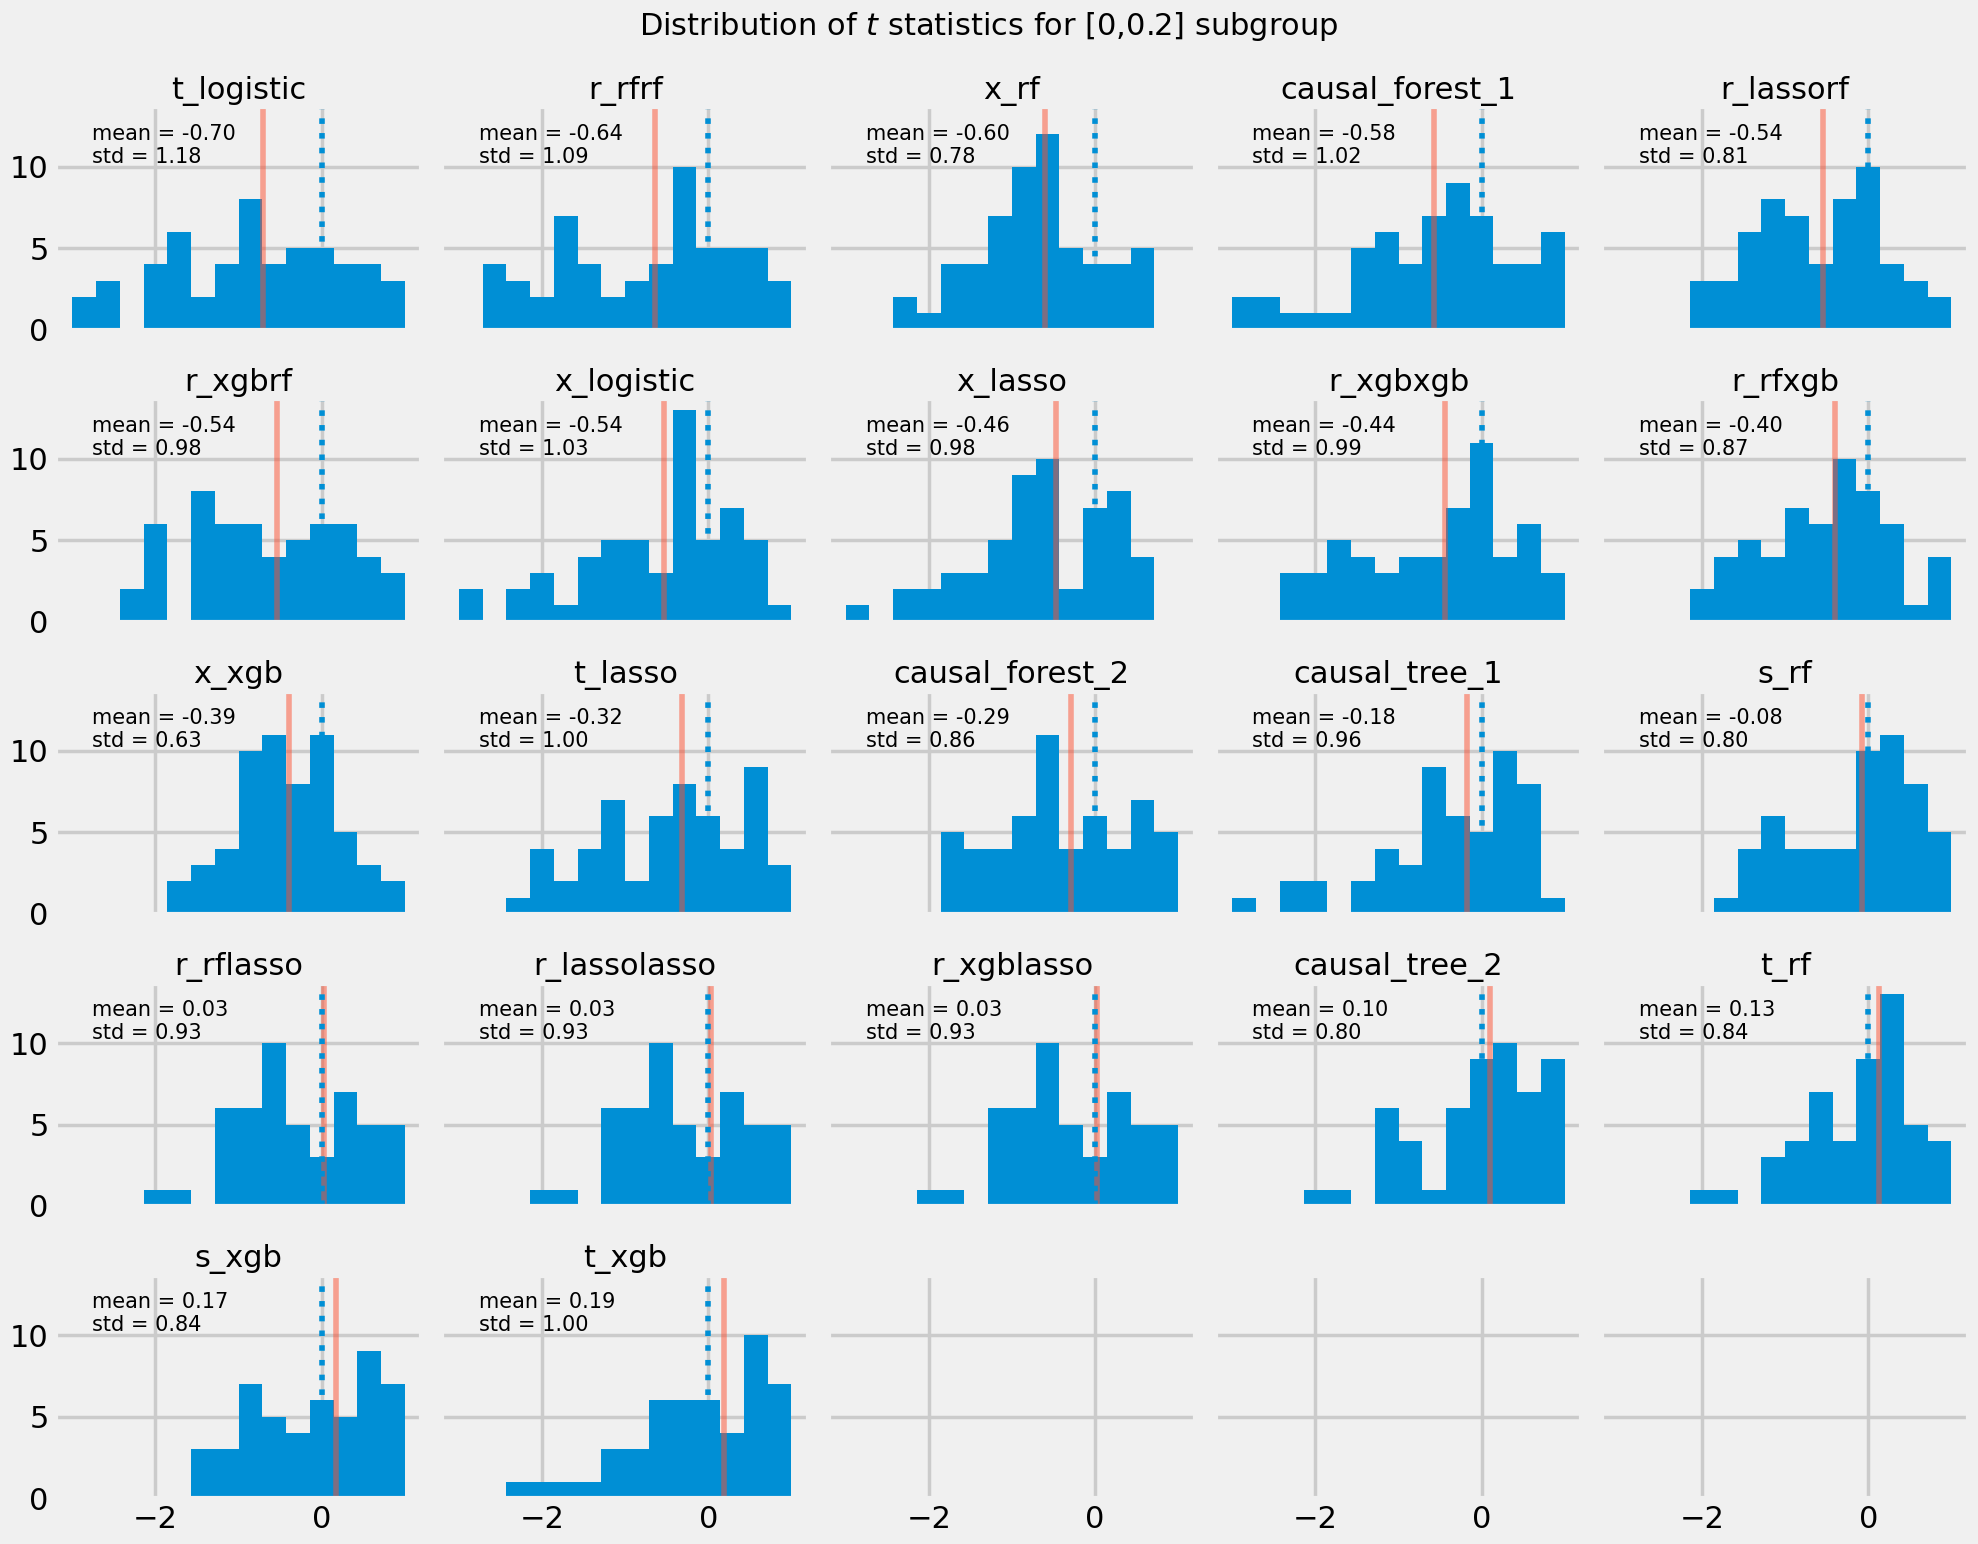

In [13]:
f, axes = plt.subplots(5, 5, figsize=[20, 15], sharex = True, sharey = True)
axes = axes.flatten()
for i, estimator in enumerate(selected_estimators):
    ax = axes[i]
    ax.hist(scores_df.loc[estimator], bins = np.linspace(-3,1,15))
    mean_score = scores_df.loc[estimator].mean()
    score_std = scores_df.loc[estimator].std()
    ax.axvline(mean_score, linestyle='-', color=colors[1], alpha=0.5)
    ax.axvline(0, alpha=1., linestyle=':')
    ax.annotate(f"mean = {mean_score:.2f}\nstd = {score_std:.2f}",
                xy = (.1, .75), xycoords = ax.transAxes,
                fontsize = 15)
    ax.set_title(estimator)
#    ax.set_xticks([-2, -1, 0, 1.])
#    plt.xlim([-2, 1])
plt.tight_layout()
plt.suptitle(r"Distribution of $t$ statistics for [0,0.2] subgroup", y = 1.03)
plt.show()

## 4. Selecting the top estimators

### 4.1. Further investigation and plots

We first return to aggregating $t$-statistics within each perturbation type.

In [19]:
results_df = aggregate_estimator_scores(scores_df, aggregation_func_name="mean", 
                                        group_by = "perturbation", dir_neg=dir_neg)
results_df = results_df.drop(index="r_lassoxgb")
results_df = results_df[[ 'pert=none', 'pert=cv_0', 'pert=cv_1']]
ranking_df = results_df.rank(ascending=False)
ranking_df["max"] = ranking_df.apply(np.max, axis = 1)
ranking_df = ranking_df.sort_values("max")

results_df = results_df.reindex(index=ranking_df.index).round(2)

In [20]:
results_df

pert=none  pert=cv_0  pert=cv_1
estimator                                       
s_xgb                 0.07      -0.04       0.47
t_rf                  0.18      -0.12       0.34
causal_tree_2        -0.08       0.05       0.35
t_xgb                 0.55      -0.63       0.64
r_rflasso            -0.00       0.06       0.03
r_xgblasso           -0.00       0.06       0.03
r_lassolasso         -0.00       0.06       0.03
causal_tree_1        -0.17      -0.60       0.24
s_rf                  0.13      -0.29      -0.06
causal_forest_2      -0.50      -0.64       0.26
x_lasso              -0.43      -0.80      -0.16
t_lasso              -0.10      -0.60      -0.25
r_rfxgb              -0.14      -1.03      -0.04
r_lassorf            -0.56      -1.01      -0.05
r_xgbxgb              0.10      -1.14      -0.30
x_xgb                -0.41      -0.41      -0.35
r_xgbrf              -0.53      -1.34       0.26
x_logistic           -0.44      -0.73      -0.43
x_rf                 -0.56      -0.73      -0.52
causal_forest_1      -0.57      -1.36       0.21
r_rfrf               -0.78      -1.37       0.24
t_logistic           -0.59      -0.88      -0.62

In [21]:
ranking_df

pert=none  pert=cv_0  pert=cv_1   max
estimator                                             
s_xgb                  5.0        5.0        2.0   5.0
t_rf                   2.0        6.0        4.0   6.0
causal_tree_2          9.0        4.0        3.0   9.0
t_xgb                  1.0       11.0        1.0  11.0
r_rflasso              7.0        2.0       11.0  11.0
r_xgblasso             7.0        2.0       11.0  11.0
r_lassolasso           7.0        2.0       11.0  11.0
causal_tree_1         12.0        9.0        7.0  12.0
s_rf                   3.0        7.0       15.0  15.0
causal_forest_2       16.0       12.0        5.0  16.0
x_lasso               14.0       15.0       16.0  16.0
t_lasso               10.0       10.0       17.0  17.0
r_rfxgb               11.0       18.0       13.0  18.0
r_lassorf             18.0       17.0       14.0  18.0
r_xgbxgb               4.0       19.0       18.0  19.0
x_xgb                 13.0        8.0       19.0  19.0
r_xgbrf               17.0       20.0        6.0  20.0
x_logistic            15.0       14.0       20.0  20.0
x_rf                  19.0       13.0       21.0  21.0
causal_forest_1       20.0       21.0        9.0  21.0
r_rfrf                22.0       22.0        8.0  22.0
t_logistic            21.0       16.0       22.0  22.0

In [17]:
# Run this to get latex code for table
#print(results_df.round(2).to_latex())

In [22]:
joblib.dump([results_df, ranking_df], f"output/analysis/{outcome_name}/{outcome_name}_t_boxplot_data.pkl")

['output/analysis/fausebal/fausebal_t_boxplot_data.pkl']

In [23]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 23
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'
SAVE_PATH  = f"figs/{outcome_name}/"


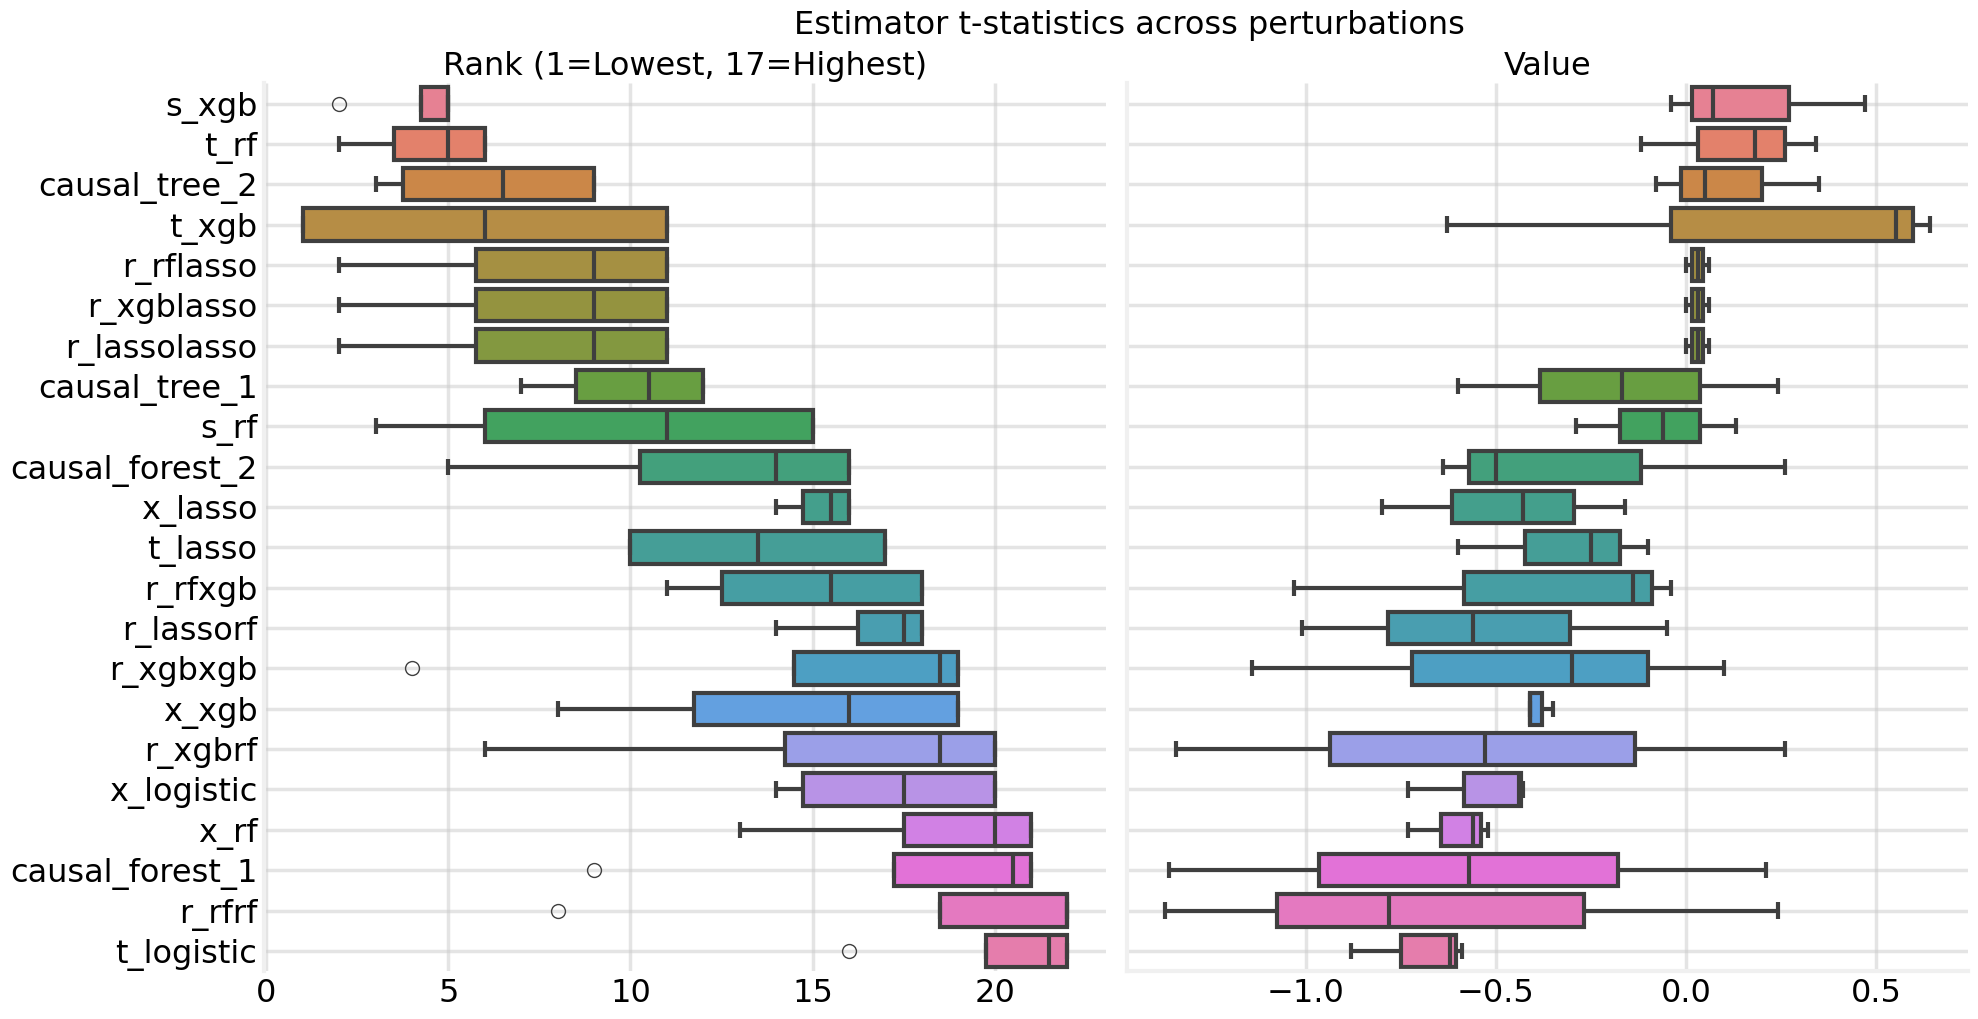

In [24]:
savfig = False
fig, axes = plt.subplots(1, 2, sharey=True, figsize=[20, 10])

ax = axes[0]
box_plot = sns.boxplot(data=ranking_df.T, orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Rank (1=Lowest, 17=Highest)", x=0.5, y=1)
ax.grid(True, alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")

ax = axes[1]
box_plot = sns.boxplot(data=results_df.reindex(index=ranking_df.index).T, orient='h',fliersize=10, linewidth=3, ax=ax)
ax.set_ylabel('')
ax.set_title("Value", y=1)
ax.grid(True,  alpha=0.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.set_xlabel("Value")
plt.tight_layout()
plt.suptitle("Estimator t-statistics across perturbations", x=0.57, y=1.02)
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome_name}_scores_rank_estimators.pdf",bbox_inches='tight')
plt.show()
# sns.boxplot(data=monotonicity_df, ax=ax, fliersize=10, linewidth=3)


### 4.2. Outputting names of top estimators

Let's isolate the estimators whose ranks (within each perturbation type) are always at most 10.

In [26]:
ranking_df = ranking_df[~ranking_df.isna().max(axis=1)]
ranking_df["max"] = ranking_df.filter(regex = "pert").max(axis = 1)
ranking_df[ranking_df["max"] <= 11]

pert=none  pert=cv_0  pert=cv_1   max
estimator                                           
s_xgb                5.0        5.0        2.0   5.0
t_rf                 2.0        6.0        4.0   6.0
causal_tree_2        9.0        4.0        3.0   9.0
t_xgb                1.0       11.0        1.0  11.0
r_rflasso            7.0        2.0       11.0  11.0
r_xgblasso           7.0        2.0       11.0  11.0
r_lassolasso         7.0        2.0       11.0  11.0

In [28]:
outcome_name = "fausebal"
top_estimator_names = list(ranking_df[ranking_df["max"] <= 11].index)
joblib.dump(top_estimator_names, f"output/analysis/{outcome_name}/{outcome_name}_top_estimator_names.pkl")

['output/analysis/fausebal/fausebal_top_estimator_names.pkl']